# Project Overview

#### Kaggle 'Competitions': Spaceship Titanic

**Main objective:** Predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. 

This project is my first attempt to put my knowledge into practice and gain a deeper understanding of how things work in this field. As a beginner, I’m excited to apply the techniques I’ve learned so far.

My initial approach will be to analyze the dataset thoroughly to identify any potential differences or patterns. I'll apply several techniques to improve the data, including using Label Encoding for categorical features, filling missing values with the mode for categorical data and the median for numerical data, and normalizing the data using StandardScaler.

I'll experiment with various models, including simpler algorithms and more advanced neural networks using TensorFlow and PyTorch. To evaluate the model performance, I will use multiple metrics such as accuracy, recall, precision, F1-score, log loss, cross-validation, ROC, AUC, confusion matrix, and also track the processing time.

To optimize the model’s performance, I will use Grid Search to fine-tune the hyperparameters and improve the results.

This project takes some time to run because I use GridSearchCV to fine-tune the hyperparameters and improve the results. However, you can comment out this part of the code and use the previously created Gradient Boosting model instead.
If anyone is interested in contributing, helping, or suggesting improvements, I would really appreciate it! I'm still learning, and any feedback is welcome.

**Final results:**

Log Loss : 0.4145 | Accuracy 0.79 | Cross-Validation 0.8063 | Precision: 0.7737 | Recall: 0.8257 |  F1-Score: 0.7989 | ROC-AUC: 0.7898

# Data
`train.csv` - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.

- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

`test.csv` - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

`sample_submission.csv` - A submission file in the correct format.
PassengerId - Id for each passenger in the test set.
Transported - The target. For each passenger, predict either True or False.

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import time
import random
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, log_loss, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# set random seeds
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

# Load the Dataset

In [2]:
training_df = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")

training_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
test_df = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


# Dataset Exploration

In [4]:
# data types and missing values
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


**Observations**
- The dataset consists of 8,693 entries (rows) and 14 columns.
- Data Types:
    - Categorical (Object): `PassengerId`, `HomePlanet`, `CryoSleep`, `Cabin`, `Destination`, `VIP`, `Name`
    - Numerical (Float64): `Age`, `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`
    - Boolean: `Transported`

In [5]:
# summary of the numerical features
training_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
training_df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
print("Duplicated rows: ", len(training_df[training_df.duplicated()]))

Duplicated rows:  0


In [8]:
training_df['HomePlanet'].value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

**Observation**
- "Europa" should belong to "Earth"

In [9]:
training_df['HomePlanet'] = training_df['HomePlanet'].replace({'Europa': 'Earth'})
training_df['HomePlanet'].value_counts()

HomePlanet
Earth    6733
Mars     1759
Name: count, dtype: int64

In [10]:
test_df['HomePlanet'] = test_df['HomePlanet'].replace({'Europa': 'Earth'})
test_df['HomePlanet'].value_counts()

HomePlanet
Earth    3265
Mars      925
Name: count, dtype: int64

#### Group Distribution by Transport Status

Since PassengerId follows the format `gggg_pp`, where `gggg` represents the group a passenger is traveling with, I can analyze whether the group influences the transport status and determine the number of passengers in each group. It's possible that larger groups are more likely to be transported.

In [11]:
training_df['GroupId'] = training_df['PassengerId'].apply(lambda p: p.split('_')[0])

In [12]:
test_df['GroupId'] = test_df['PassengerId'].apply(lambda p: p.split('_')[0])

In [13]:
group_df = training_df.groupby('GroupId')

group_passengers = group_df['PassengerId'].count().reset_index()

# Rename 'PassengerId' to 'TotalPassengers'
group_size = group_passengers.rename(columns={'PassengerId': 'TotalPassengers'})

group_size_sorted = group_size.sort_values(by='TotalPassengers', ascending=False).iloc[:20]

group_size_sorted.head()

,GroupId,TotalPassengers
3023,4498,8
5487,8168,8
5851,8728,8
5893,8796,8
6000,8956,8


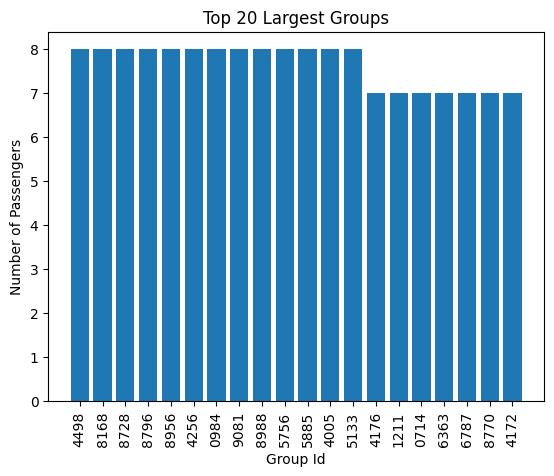

In [14]:
plt.bar(group_size_sorted['GroupId'], group_size_sorted['TotalPassengers'])
plt.xticks(rotation=90)
plt.xlabel("Group Id")
plt.ylabel("Number of Passengers")
plt.title("Top 20 Largest Groups")
plt.show()

In [15]:
group_transport_status = group_df['Transported'].apply(list).reset_index()

# Count the number of 'True' and 'False' values in each group
group_transport_status['TrueCount'] = group_transport_status['Transported'].apply(lambda t: t.count(True))
group_transport_status['FalseCount'] = group_transport_status['Transported'].apply(lambda t: t.count(False))

# Calculate the total number of passengers in each group (TrueCount + FalseCount)
group_transport_status['TotalCount'] = group_transport_status['TrueCount'] + group_transport_status['FalseCount']

group_transport_status_sorted = group_transport_status.sort_values(by='TotalCount', ascending=False).iloc[:20]

group_transport_status_sorted.head()

,GroupId,Transported,TrueCount,FalseCount,TotalCount
3023,4498,"[False, False, True, False, True, True, False,...",3,5,8
5487,8168,"[False, False, False, False, False, True, True...",3,5,8
5851,8728,"[True, False, False, False, True, False, False...",3,5,8
5893,8796,"[True, False, False, False, False, True, True,...",4,4,8
6000,8956,"[False, True, False, False, False, False, Fals...",1,7,8


<Figure size 1200x600 with 0 Axes>

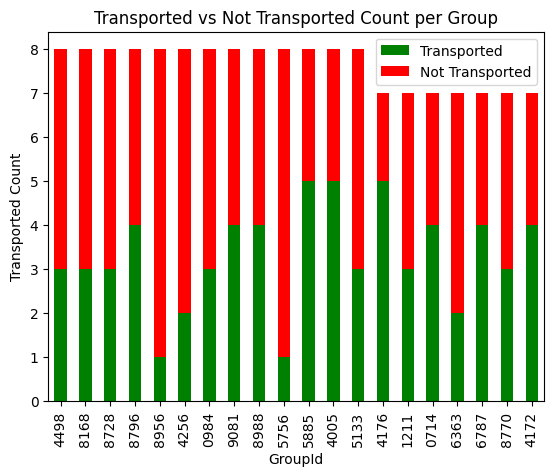

In [16]:
plt.figure(figsize=(12,6))
ax = group_transport_status_sorted[['TrueCount', 'FalseCount']].plot(kind='bar', stacked=True, color=['green', 'red'])
plt.xlabel('GroupId')
plt.ylabel('Transported Count')
plt.title('Transported vs Not Transported Count per Group')
plt.xticks(ticks=range(len(group_transport_status_sorted)), labels=group_transport_status_sorted['GroupId'], rotation=90)
ax.legend(['Transported', 'Not Transported'], loc='upper right')
plt.show()

**Observation**
- Groups vary in size from 1 to 8 passengers
- It seems that may not have uniform transport status

#### Distribution of Transported

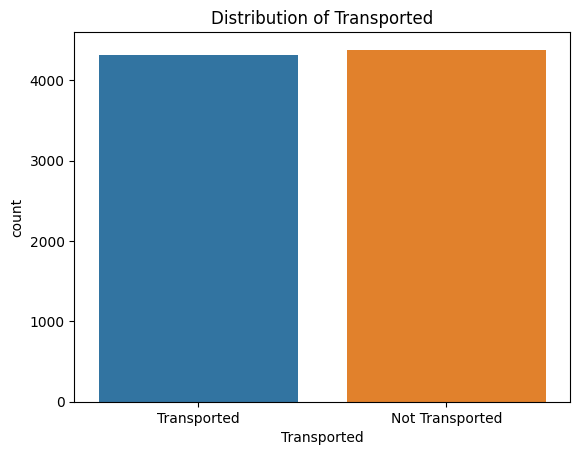

In [17]:
# Distribution of Transported
sns.countplot(data= training_df, x = 'Transported')
plt.title('Distribution of Transported')
plt.xticks([0, 1], ['Transported', 'Not Transported'])
plt.show()

**Observation**
- The distribution between the two values is relatively balanced

#### Age Distribution by Transport Status

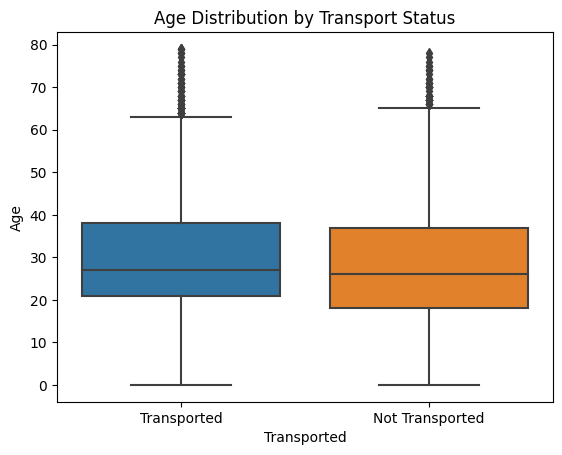

In [18]:
sns.boxplot(data=training_df, x='Transported', y='Age')
plt.title('Age Distribution by Transport Status')
plt.xticks([0, 1], ['Transported', 'Not Transported'])
plt.show()

**Observation**
- Both "Transported" and "Not Transported" groups have similar box plots
- There is no visible difference in the age distribution between the two groups
- Age might not be a significant factor in determining whether passengers are transported or not

#### Amount Spent in Amenities by Transport Status

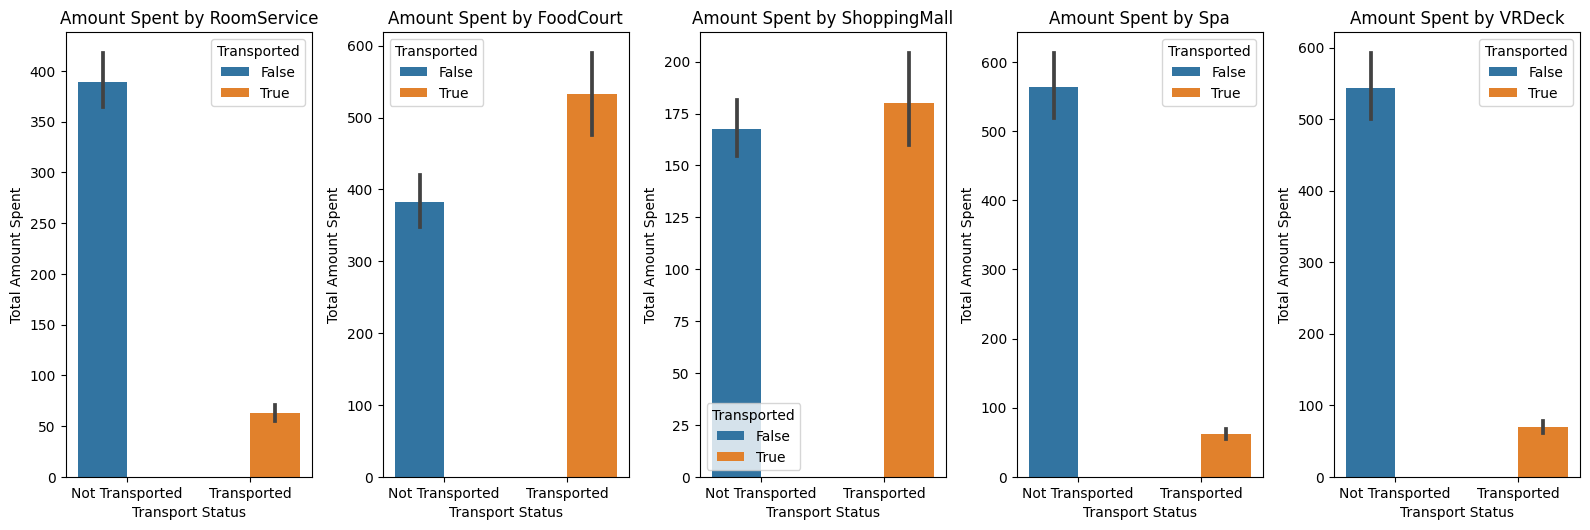

In [19]:
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

plt.figure(figsize=(16, 10))

for i, amenity in enumerate(amenities, 1):

    total_spent = training_df.groupby(['Transported'])[amenity].sum()

    plt.subplot(2, 5, i)
    sns.barplot(data=training_df, x='Transported', y=amenity, hue='Transported')
    plt.title(f'Amount Spent by {amenity}')
    plt.xlabel('Transport Status')
    plt.ylabel('Total Amount Spent')
    plt.xticks([0, 1], ['Not Transported', 'Transported'])

plt.tight_layout()
plt.show()

**Observation**
- Transported passengers tend to use the FoodCourt and ShoppingMall amenities more than non-transported passengers
- Some transported passengers might have spent significantly more, while others spent little or nothing at all

#### Distribution of Transport Status by HomePlanet

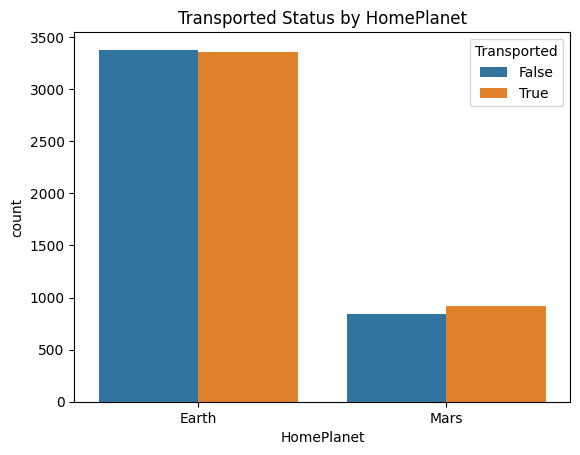

In [20]:
sns.countplot(data=training_df,x='HomePlanet', hue='Transported')
plt.title('Transported Status by HomePlanet')
plt.show()

**Observation**
- Earth has the largest number of passengers
- Earth has almost the same quantity of non-transported and transported passengers

#### Distribution of Transport Status by CryoSleep

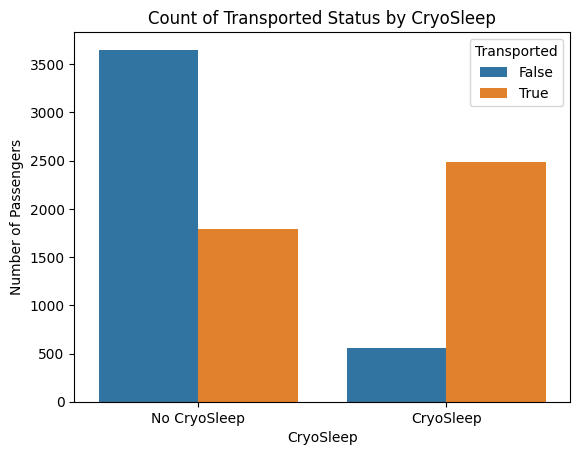

In [21]:
sns.countplot(data=training_df, x='CryoSleep', hue='Transported')
plt.title('Count of Transported Status by CryoSleep')
plt.ylabel('Number of Passengers')
plt.xlabel('CryoSleep')
plt.xticks([0, 1], ['No CryoSleep', 'CryoSleep'])
plt.show()

**Observation**
- Passengers who didn't opted for CryoSleep are much less likely to be transported compared to those who opted for CryoSleep

# Data Cleaning

In [22]:
def split_cabin(df):
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df['Side'] = df['Side'].map({'P': 0, 'S': 1})  # Port = 0, Starboard = 1
    return df

In [23]:
training_df['Transported'] = training_df['Transported'].astype(int)

In [24]:
training_df = split_cabin(training_df)

test_df = split_cabin(test_df)

Drop unnecessary columns

In [25]:
training_df.drop(columns=['PassengerId', 'Cabin', 'Name'], inplace=True)

test_df.drop(columns=['PassengerId', 'Cabin', 'Name'], inplace=True)

Fill Missing Values

In [26]:
categorical_columns = training_df.select_dtypes(include='object').columns
categorical_columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'GroupId', 'Deck',
       'Num'],
      dtype='object')

In [27]:
label_encoder = LabelEncoder()

def label_encode_columns(df, columns):
    for col in columns:
        df[col] = label_encoder.fit_transform(df[col])
    return df

In [28]:
numerical_columns = training_df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    training_df[col] = training_df[col].fillna(training_df[col].median())

numerical_columns = test_df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    test_df[col] = test_df[col].fillna(test_df[col].median())

In [29]:
pd.set_option("future.no_silent_downcasting", True)

for col in training_df.select_dtypes(include='object'):
    training_df[col] = training_df[col].fillna(training_df[col].mode()[0])

    training_df = training_df.infer_objects()

for col in test_df.select_dtypes(include='object'):
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])
    
    test_df = test_df.infer_objects()

In [30]:
training_df.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
GroupId         0
Deck            0
Num             0
Side            0
dtype: int64

In [31]:
test_df.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
GroupId         0
Deck            0
Num             0
Side            0
dtype: int64

Handling Categorical Features

In [32]:
training_df = label_encode_columns(training_df, categorical_columns)

test_df = label_encode_columns(test_df, categorical_columns)

In [33]:
training_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,Deck,Num,Side
0,0,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0.0
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1,1,5,0,1.0
2,0,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,2,0,0,1.0
3,0,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,2,0,0,1.0
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1,3,5,1,1.0


In [34]:
test_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,Deck,Num,Side
0,0,1,2,27.0,0,0.0,0.0,0.0,0.0,0.0,0,6,820,1.0
1,0,0,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,1,5,927,1.0
2,0,1,0,31.0,0,0.0,0.0,0.0,0.0,0.0,2,2,0,1.0
3,0,0,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,3,2,1,1.0
4,0,0,2,20.0,0,10.0,0.0,635.0,0.0,0.0,4,5,1029,1.0


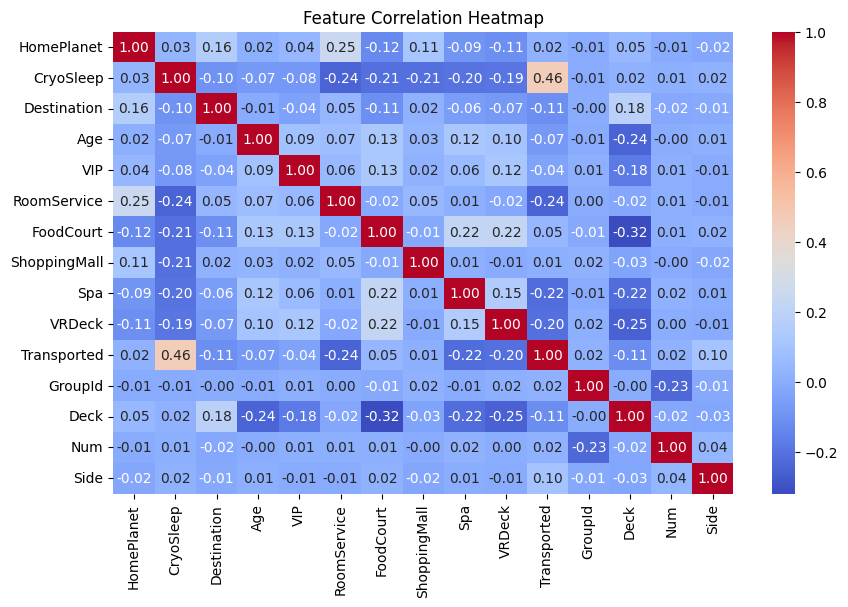

In [35]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(training_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

**Observation**
- There is a moderate positive correlation between Transported and CryoSleep (0.46)
- There is a slight negative correlation between RoomService usage and being Transported (-0.24)
- There is a slight negative correlation between Spa usage and being Transported (-0.22)

# Data Preprocessing

In [36]:
X = training_df.drop('Transported', axis=1)
y = training_df['Transported']

print(f"Shape of X: {X.shape} ; Y: {y.shape}")

Shape of X: (8693, 14) ; Y: (8693,)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling

In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models

In [39]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=43),
    "Gradient Boosting": GradientBoostingClassifier(random_state=44),
    "XGBClassifier": XGBClassifier(random_state=45),
}

# Train models

In [40]:
results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train_scaled, y_train)
    y_preds = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_preds)
    training_time = time.time() - start
    results.append((name, accuracy, training_time))

# Evaluate models

In [41]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Training Time (s)"])

In [42]:
results_df = results_df.sort_values(by=["Training Time (s)", "Accuracy"], ascending=[True, False])

In [43]:
results_df

,Model,Accuracy,Training Time (s)
0,Logistic Regression,0.774008,0.022357
3,XGBClassifier,0.786084,0.156790
1,Random Forest,0.788959,1.110363
2,Gradient Boosting,0.792984,1.345035


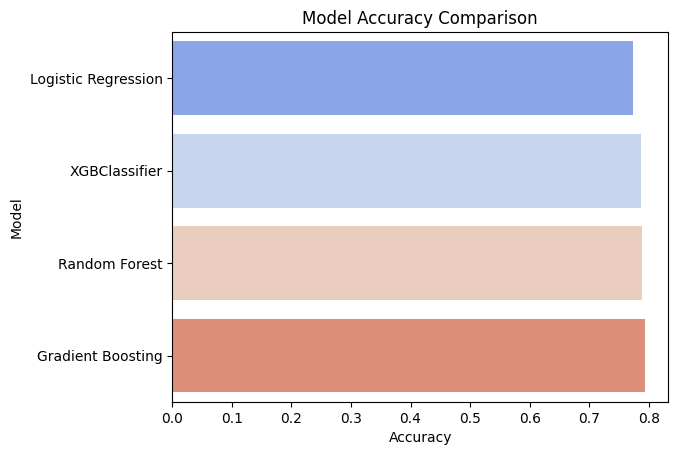

In [44]:
ax = sns.barplot(data=results_df, x="Accuracy", y="Model", hue="Model", palette="coolwarm", dodge=False)
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")

ax.legend_.remove()
plt.show()

#### Visualization of Overall Ranking based on Speed and Accuracy

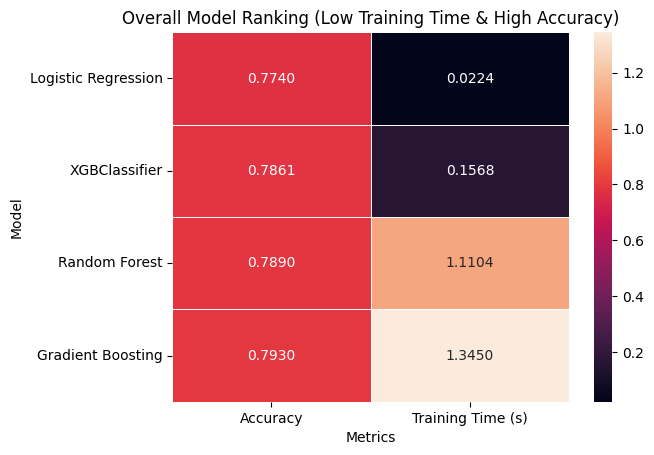

In [45]:
sns.heatmap(results_df.set_index("Model"), annot=True, linewidths=0.5, fmt=".4f")
plt.title("Overall Model Ranking (Low Training Time & High Accuracy)")
plt.xlabel("Metrics")
plt.ylabel("Model")
plt.show()

**Observation**
- Accuracy Comparison
    - Gradient Boosting (0.7929) → Highest accuracy
    - Random Forest (0.7889) → Second highest accuracy
    - XGBoost (0.7860) → Slightly lower
    - Logistic Regression (0.7740) → Lowest

Winner in Accuracy: Gradient Boosting (0.7929)

- Training Time Comparison
    - Logistic Regression (0.0097s) → Fastest
    - XGBoost (0.1298s) → 2nd fastest
    - Random Forest (0.7591s) → Slower
    - Gradient Boosting (0.9370s) → Slowest

Winner in Speed: Logistic Regression

**Final Observation**
- Highest accuracy - Gradient Boosting
- A balance of speed and accuracy - XGBoost

In [46]:
gradient_boosting = models["Gradient Boosting"]
xgboost = models["XGBClassifier"]

In [47]:
gb_scores = cross_val_score(gradient_boosting, X_train_scaled, y_train, cv=10, scoring='accuracy')
xgb_scores = cross_val_score(xgboost, X_train_scaled, y_train, cv=10, scoring='accuracy')

print(f"Gradient Boosting CV Accuracy: {gb_scores.mean():.4f}")
print(f"XGBoost CV Accuracy: {xgb_scores.mean():.4f}")

Gradient Boosting CV Accuracy: 0.8030
XGBoost CV Accuracy: 0.7988


**Observation**

Gradient Boosting performed slightly better in terms of accuracy

#### Metrics to evaluate the two models

- Check features importances

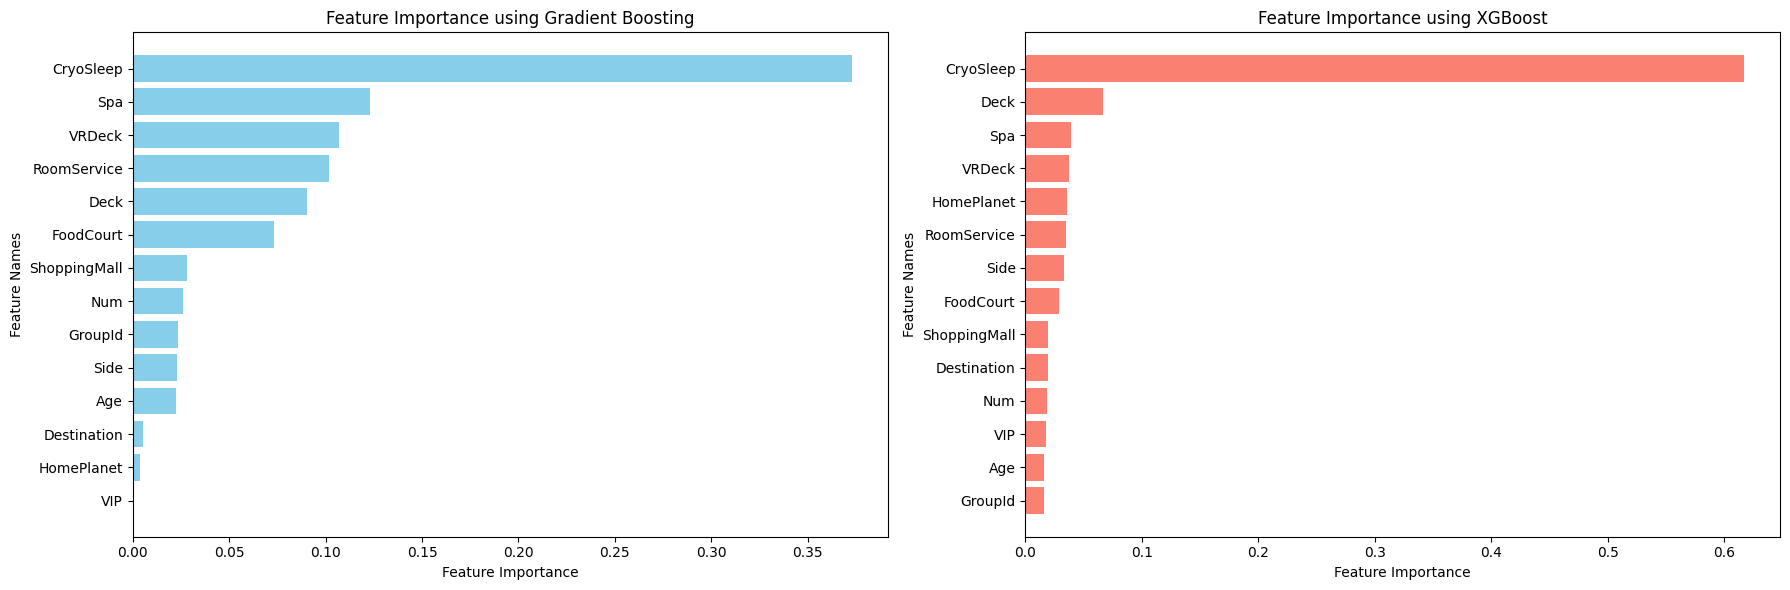

In [48]:
features_names = X_train.columns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot for Gradient Boosting
importances_gb = gradient_boosting.feature_importances_
sorted_idx_gb = np.argsort(importances_gb)
ax1.barh(features_names[sorted_idx_gb], importances_gb[sorted_idx_gb], color='skyblue')
ax1.set_xlabel("Feature Importance")
ax1.set_ylabel("Feature Names")
ax1.set_title("Feature Importance using Gradient Boosting")

# Plot for XGBoost
importances_xgb = xgboost.feature_importances_
sorted_idx_xgb = np.argsort(importances_xgb)
ax2.barh(features_names[sorted_idx_xgb], importances_xgb[sorted_idx_xgb], color='salmon')
ax2.set_xlabel("Feature Importance")
ax2.set_ylabel("Feature Names")
ax2.set_title("Feature Importance using XGBoost")

plt.tight_layout()
plt.show()

**Observation**

The 5 most important and common features for both models are:
- CryoSleep
- Spa
- VRDeck
- Room Service
- Deck

- Check performance metrics

In [49]:
y_preds_gb = gradient_boosting.predict(X_test_scaled)
y_preds_xgb = xgboost.predict(X_test_scaled)

In [50]:
# Calculate performance metrics for Gradient Boosting
precision_gb = precision_score(y_test, y_preds_gb)
recall_gb = recall_score(y_test, y_preds_gb)
f1_score_gb = f1_score(y_test, y_preds_gb)
roc_auc_gb = roc_auc_score(y_test, y_preds_gb)

# Calculate performance metrics for XGBoost
precision_xgb = precision_score(y_test, y_preds_xgb)
recall_xgb = recall_score(y_test, y_preds_xgb)
f1_score_xgb = f1_score(y_test, y_preds_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_preds_xgb)

print("Gradient Boosting Metrics:")
print(f"Precision: {precision_gb:.4f}")
print(f"Recall: {recall_gb:.4f}")
print(f"F1-Score: {f1_score_gb:.4f}")
print(f"ROC-AUC: {roc_auc_gb:.4f}")

print("\nXGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-Score: {f1_score_xgb:.4f}")
print(f"ROC-AUC: {roc_auc_xgb:.4f}")

Gradient Boosting Metrics:
Precision: 0.7692
Recall: 0.8428
F1-Score: 0.8043
ROC-AUC: 0.7925

XGBoost Metrics:
Precision: 0.7882
Recall: 0.7882
F1-Score: 0.7882
ROC-AUC: 0.7861


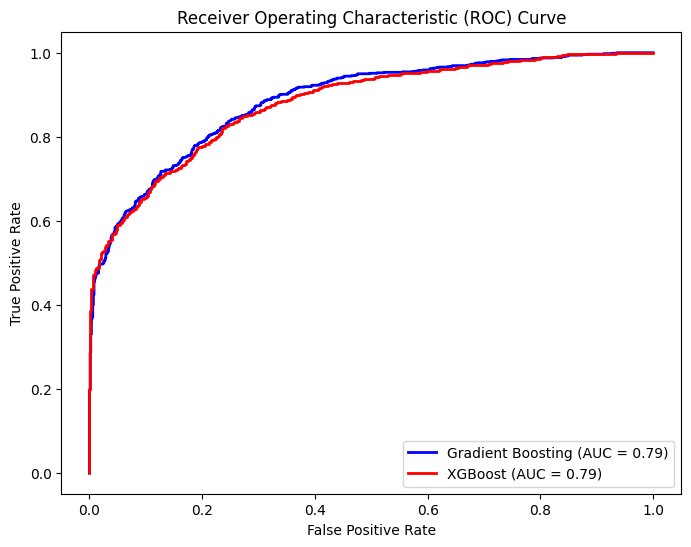

In [51]:
# Plot ROC Curves
fpr_gb, tpr_gb, _ = roc_curve(y_test, gradient_boosting.predict_proba(X_test_scaled)[:, 1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgboost.predict_proba(X_test_scaled)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='blue', lw=2, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

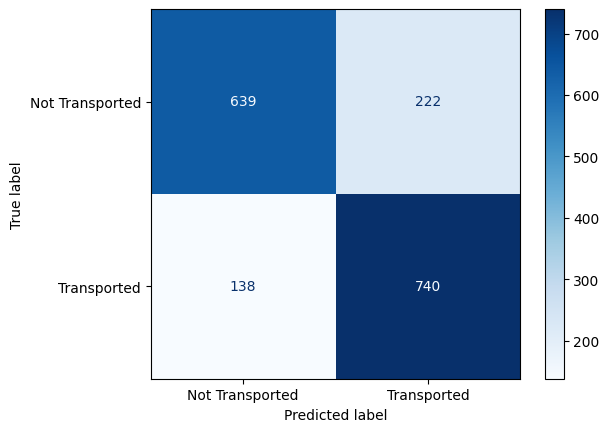

In [52]:
# Confusion Matrix
cm_gb = confusion_matrix(y_test, y_preds_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=['Not Transported', 'Transported'])
disp.plot(cmap='Blues')
plt.show()

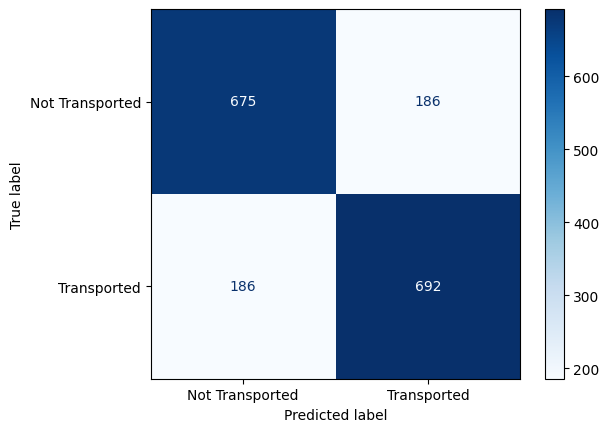

In [53]:
cm_xgb = confusion_matrix(y_test, y_preds_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Not Transported', 'Transported'])
disp.plot(cmap='Blues')
plt.show()

In [54]:
classification_report_gb = classification_report(y_test, y_preds_gb)
print(classification_report_gb)

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       861
           1       0.77      0.84      0.80       878

    accuracy                           0.79      1739
   macro avg       0.80      0.79      0.79      1739
weighted avg       0.80      0.79      0.79      1739



In [55]:
classification_report_xgb = classification_report(y_test, y_preds_xgb)
print(classification_report_xgb)

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       861
           1       0.79      0.79      0.79       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



**Observation**
- Gradient Boosting:
    - Higher recall: Better at identifying true positives (passengers who were transported).
    - Better F1-Score: A more balanced model, considering both false positives and false negatives.
    - Higher ROC-AUC: Better overall at distinguishing between the classes.
- XGBoost:
    - Higher precision: Better at reducing false positives (fewer passengers incorrectly predicted as transported).
    - More consistent performance: Precision, recall, and F1-score are all the same, suggesting that it balances false positives and false negatives evenly but not as well as Gradient Boosting.

In [56]:
# Compute log loss
y_pred_prob_gb = gradient_boosting.predict_proba(X_test_scaled)

loss = log_loss(y_test, y_pred_prob_gb)
print(f"Log Loss: {loss:.4f}")

Log Loss: 0.4225


# Model Improvement

In [57]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(gradient_boosting, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

start_time = time.time()

grid_search.fit(X_train_scaled, y_train)

time_taken  = time.time() - start_time

print(f"GridSearchCV took {time_taken:.2f} seconds")
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
GridSearchCV took 4396.92 seconds
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 1.0}
Best Score: 0.8098942327087288


In [58]:
best_gb = grid_search.best_estimator_

In [59]:
# Cross-validation
gb_cv_scores = cross_val_score(best_gb, X_train_scaled, y_train, cv=10, scoring='accuracy')

print(f"Cross-validation Accuracy: {gb_cv_scores.mean():.4f}")

Cross-validation Accuracy: 0.8063


In [60]:
y_preds_gb = best_gb.predict(X_test_scaled)

In [61]:
# Calculate performance metrics for Gradient Boosting
precision_gb = precision_score(y_test, y_preds_gb)
recall_gb = recall_score(y_test, y_preds_gb)
f1_score_gb = f1_score(y_test, y_preds_gb)
roc_auc_gb = roc_auc_score(y_test, y_preds_gb)

print("Gradient Boosting Metrics:")
print(f"Precision: {precision_gb:.4f}")
print(f"Recall: {recall_gb:.4f}")
print(f"F1-Score: {f1_score_gb:.4f}")
print(f"ROC-AUC: {roc_auc_gb:.4f}")

Gradient Boosting Metrics:
Precision: 0.7737
Recall: 0.8257
F1-Score: 0.7989
ROC-AUC: 0.7898


In [62]:
# Classification Report (Precision, Recall, F1-Score)
print("Classification Report:\n", classification_report(y_test, y_preds_gb))

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78       861
           1       0.77      0.83      0.80       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [63]:
# Compute log loss
y_pred_prob_gb = best_gb.predict_proba(X_test_scaled)

loss = log_loss(y_test, y_pred_prob_gb)
print(f"Log Loss: {loss:.4f}")

Log Loss: 0.4145


**Observation**
- Log Loss Decreased (from 0.4225 to 0.4145):
The model's predicted probabilities are better calibrated after hyperparameter tuning, suggesting the new model is more confident in its predictions.

- Accuracy Remained the Same (0.79):
While accuracy didn't change, the improvement in log loss indicates better probability estimation.

- Cross-Validation Accuracy Improved (0.8030 → 0.8063):
The model shows a slight improvement in generalization, performing more consistently across validation folds.

The fine-tuned Gradient Boosting model is better because:
- It has a lower log loss (better probability estimation).
- It has a slightly better cross-validation accuracy.
- There is no degradation in accuracy, precision, recall, or F1-score.

# Compare results to neural networks (With tensorflow and Pytorch)

- With tensorflow

In [64]:
# Define the model architecture
model_tf = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_tf.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_tf.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=2)

Epoch 1/10
218/218 - 2s - 10ms/step - accuracy: 0.7485 - loss: 0.5082 - val_accuracy: 0.7838 - val_loss: 0.4592
Epoch 2/10
218/218 - 0s - 2ms/step - accuracy: 0.7957 - loss: 0.4320 - val_accuracy: 0.7867 - val_loss: 0.4500
Epoch 3/10
218/218 - 0s - 2ms/step - accuracy: 0.7994 - loss: 0.4210 - val_accuracy: 0.7821 - val_loss: 0.4469
Epoch 4/10
218/218 - 0s - 2ms/step - accuracy: 0.8011 - loss: 0.4144 - val_accuracy: 0.7826 - val_loss: 0.4433
Epoch 5/10
218/218 - 0s - 2ms/step - accuracy: 0.8051 - loss: 0.4090 - val_accuracy: 0.7844 - val_loss: 0.4410
Epoch 6/10
218/218 - 0s - 2ms/step - accuracy: 0.8057 - loss: 0.4045 - val_accuracy: 0.7872 - val_loss: 0.4387
Epoch 7/10
218/218 - 0s - 2ms/step - accuracy: 0.8076 - loss: 0.4003 - val_accuracy: 0.7890 - val_loss: 0.4364
Epoch 8/10
218/218 - 0s - 2ms/step - accuracy: 0.8097 - loss: 0.3963 - val_accuracy: 0.7901 - val_loss: 0.4346
Epoch 9/10
218/218 - 0s - 2ms/step - accuracy: 0.8106 - loss: 0.3927 - val_accuracy: 0.7872 - val_loss: 0.4333


In [65]:
# Make predictions
threshold = 0.5
y_preds_nn_prob = model_tf.predict(X_test_scaled)
y_preds_nn_class = (y_preds_nn_prob > threshold).astype(int) # Convert probabilities to class labels (0 or 1)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [66]:
# Calculate performance metrics for Neural Network
precision_nn = precision_score(y_test, y_preds_nn_class)
recall_nn = recall_score(y_test, y_preds_nn_class)
f1_score_nn = f1_score(y_test, y_preds_nn_class)
roc_auc_nn = roc_auc_score(y_test, y_preds_nn_prob)

print("Neural Network Metrics:")
print(f"Precision: {precision_nn:.4f}")
print(f"Recall: {recall_nn:.4f}")
print(f"F1-Score: {f1_score_nn:.4f}")
print(f"ROC-AUC: {roc_auc_nn:.4f}")

Neural Network Metrics:
Precision: 0.7571
Recall: 0.8451
F1-Score: 0.7987
ROC-AUC: 0.8826


In [67]:
classification_report_nn = classification_report(y_test, y_preds_nn_class)
print(classification_report_nn)

              precision    recall  f1-score   support

           0       0.82      0.72      0.77       861
           1       0.76      0.85      0.80       878

    accuracy                           0.78      1739
   macro avg       0.79      0.78      0.78      1739
weighted avg       0.79      0.78      0.78      1739



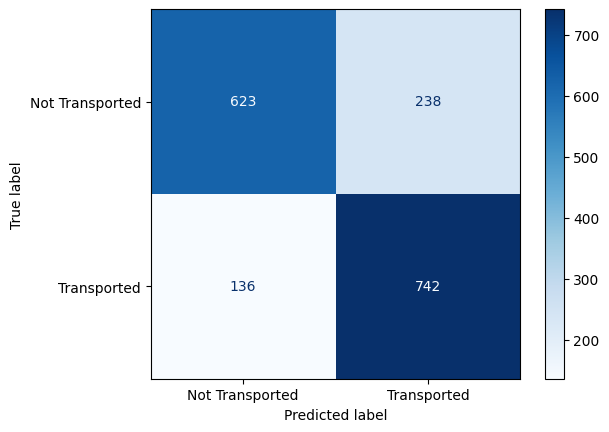

In [68]:
# Confusion Matrix
cm_nn = confusion_matrix(y_test, y_preds_nn_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=['Not Transported', 'Transported'])
disp.plot(cmap='Blues')
plt.show()

In [69]:
loss = log_loss(y_test, y_preds_nn_prob)
print(f"Log Loss: {loss:.4f}")

Log Loss: 0.4328


**Observation**

- Precision:
Gradient Boosting (0.7737) has a slightly higher precision compared to Neural Network (0.7571).
This means that Gradient Boosting is better at predicting the positive class (class 1) with fewer false positives compared to the Neural Network.

- Recall:
Neural Network (0.8451) has a higher recall than Gradient Boosting (0.8257).
This means that Neural Network is better at identifying positive instances (class 1) — it has fewer false negatives compared to the Gradient Boosting model.

- F1-Score:
Both models have very similar F1-Scores. Gradient Boosting (0.7989) has a slightly higher F1-Score than Neural Network (0.7987).
The F1-Score is a balance between Precision and Recall, and the two models perform nearly the same on this metric.

- ROC-AUC:
Neural Network (0.8826) has a significantly higher ROC-AUC than Gradient Boosting (0.7898).
The ROC-AUC reflects the model's ability to distinguish between the two classes. A higher ROC-AUC score indicates that the Neural Network is better at distinguishing between class 0 and class 1 across different thresholds.

- Log Loss:
Gradient Boosting (0.4145) has a lower log loss compared to Neural Network (0.4328).
A lower log loss indicates that the model's predicted probabilities are more accurate and well-calibrated. In this case, Gradient Boosting seems to be producing more reliable probability estimates for class 1.

For this problem, I think recall should be prioritized because I want to maximize the number of passengers who were actually transported and ensure that they are all identified, even if it means I might have a few more false positives.
I will choose the Neural Network as my model to predict the results.

- With pytorch

In [70]:
# Convert to Pytorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [71]:
# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [72]:
# Define the model architecture
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x)) # Output is a probability (between 0 and 1)
        return x

In [73]:
# Instantiate the model, loss function, and optimizer
input_size = X_train.shape[1]
model = SimpleNN(input_size)
criterion = nn.BCELoss() # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [74]:
# Train the model
epochs = 20
losses = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/20, Loss: 0.5175
Epoch 2/20, Loss: 0.4343
Epoch 3/20, Loss: 0.4242
Epoch 4/20, Loss: 0.4179
Epoch 5/20, Loss: 0.4129
Epoch 6/20, Loss: 0.4063
Epoch 7/20, Loss: 0.4035
Epoch 8/20, Loss: 0.3989
Epoch 9/20, Loss: 0.3968
Epoch 10/20, Loss: 0.3964
Epoch 11/20, Loss: 0.3916
Epoch 12/20, Loss: 0.3884
Epoch 13/20, Loss: 0.3863
Epoch 14/20, Loss: 0.3846
Epoch 15/20, Loss: 0.3828
Epoch 16/20, Loss: 0.3792
Epoch 17/20, Loss: 0.3778
Epoch 18/20, Loss: 0.3762
Epoch 19/20, Loss: 0.3745
Epoch 20/20, Loss: 0.3747


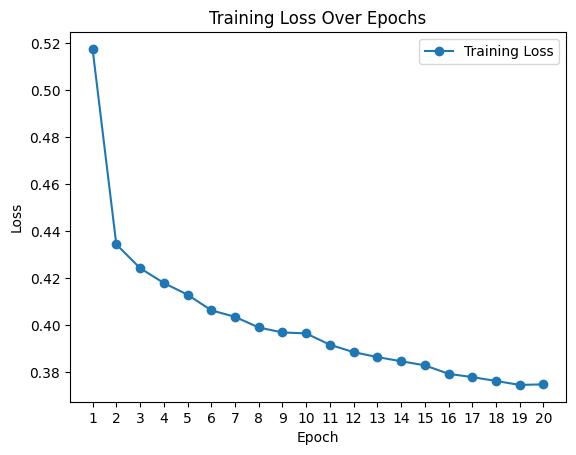

In [75]:
# Plot training loss
plt.figure()
plt.plot(range(1,21), losses, marker='o', label='Training Loss')
plt.xticks(range(1,21))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [76]:
# Evaluate model
model.eval()
y_preds = []
y_trues = []
threshold = 0.5
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        y_preds.extend(outputs.cpu().numpy())
        y_trues.extend(labels.cpu().numpy())

y_preds = np.array(y_preds)
y_preds_class = (y_preds > threshold).astype(int)

In [77]:
# Calculate performance metrics
accuracy_nn = accuracy_score(y_trues, y_preds_class)
precision_nn = precision_score(y_trues, y_preds_class)
recall_nn = recall_score(y_trues, y_preds_class)
f1_score_nn = f1_score(y_trues, y_preds_class)
log_loss_nn = log_loss(y_trues, y_preds)
roc_auc_nn = roc_auc_score(y_trues, y_preds)

print("Neural Network Metrics:")
print(f"Accuracy: {accuracy_nn:.4f}")
print(f"Precision: {precision_nn:.4f}")
print(f"Recall: {recall_nn:.4f}")
print(f"F1-Score: {f1_score_nn:.4f}")
print(f"Log Loss: {log_loss_nn:.4f}")
print(f"ROC-AUC: {roc_auc_nn:.4f}")

Neural Network Metrics:
Accuracy: 0.7826
Precision: 0.7815
Recall: 0.7904
F1-Score: 0.7860
Log Loss: 0.4204
ROC-AUC: 0.8852


# Predict and submit data

In [80]:
X_test_scaled = scaler.transform(test_df)

model_tf_predictions = model_tf.predict(X_test_scaled)

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [81]:
# Load sample submission
submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

# Assign predictions
submission['Transported'] = model_tf_predictions
submission['Transported'] = submission['Transported'].astype(bool)
submission.to_csv('/kaggle/working/submission.csv', index=False)

# Display the saved file
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,True
2,0019_01,True
3,0021_01,True
4,0023_01,True
